In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurementTable = Base.classes.measurement
stationTable = Base.classes.station

In [52]:
# Create our session (link) from Python to the DB
session = Session(engine)
columnsMeasurementTable = session.query(measurementTable).first()
print(columnsMeasurementTable.__dict__)

columnsStationTable = session.query(stationTable).first()
print(columnsStationTable.__dict__)

def printResults(queryResult, varList):
    for row in queryResult:
        strList = ""
        for index in range(len(varList)):
            strList += "  " + f"{row[index]}"
        print(strList)

joinColumns = [measurementTable.id, stationTable.id, measurementTable.station, stationTable.name, measurementTable.date, measurementTable.tobs, measurementTable.prcp,  stationTable.latitude, stationTable.longitude, stationTable.elevation]
# print(session.query(measurementTable).group_by(measurementTable.station).count())
# print(session.query(stationTable).group_by(stationTable.station).count())

queryJoin = session.query(*joinColumns).filter(measurementTable.station == stationTable.station)
printResults(queryJoin, joinColumns)
# for row in session.query(*joinColumns).filter(measurementTable.station == stationTable.station):
#     (m_id, s_id, m_stat, s_name, m_date, m_tobs, m_prcp, s_lat, s_long, s_elev) = row
#     print(f"{m_stat} {m_date} tobs: {m_tobs}  prcp: {m_prcp}  lat: {s_lat:.2f} long: {s_long:.2f}  name: {s_name}  elev: {s_elev}")

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000170D41BDF90>, 'station': 'USC00519397', 'date': '2010-01-01', 'tobs': 65.0, 'prcp': 0.08, 'id': 1}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x00000170D41BEA40>, 'latitude': 21.2716, 'id': 1, 'elevation': 3.0, 'name': 'WAIKIKI 717.2, HI US', 'station': 'USC00519397', 'longitude': -157.8168}
  1  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-01  65.0  0.08  21.2716  -157.8168  3.0
  2  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-02  63.0  0.0  21.2716  -157.8168  3.0
  3  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-03  74.0  0.0  21.2716  -157.8168  3.0
  4  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-04  76.0  0.0  21.2716  -157.8168  3.0
  5  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-06  73.0  None  21.2716  -157.8168  3.0
  6  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-07  70.0  0.06  21.2716  -157.8168  3.0
  7  1  USC00519397  WAIKIKI 717.2, HI US  2010-01-08  64.0  0

# Exploratory Precipitation Analysis

In [48]:
# Find the most recent date in the data set.
meaTableQ = session.query(measurementTable.date).order_by(measurementTable.date.desc()).first()
meaTableQ

('2017-08-23',)

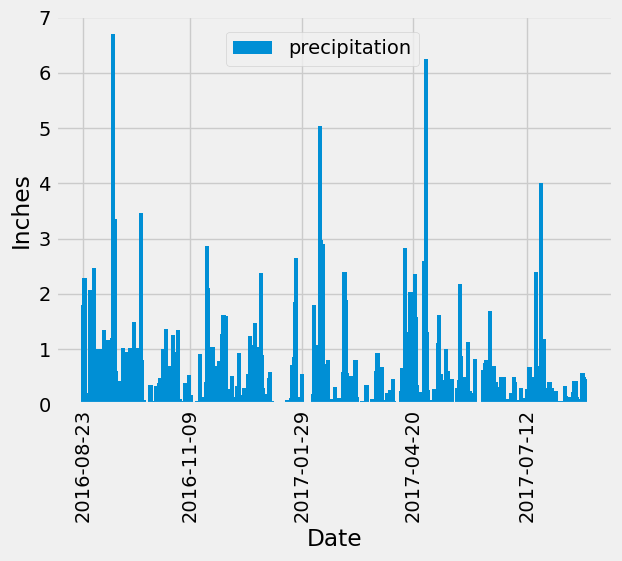

In [131]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
mostRecentDate = dt.date(int(meaTableQ[0][:4]), int(meaTableQ[0][5:7]), int(meaTableQ[0][8:10]))
oneYearBefore = mostRecentDate - dt.timedelta(days=365)
oneYearBefore

# Perform a query to retrieve the data and precipitation scores
recent12Months = session.query(measurementTable.date, measurementTable.prcp).filter(measurementTable.date >= oneYearBefore)



# Save the query results as a Pandas DataFrame. Explicitly set the column names
twelveMonthRain_df = pd.DataFrame(recent12Months, columns=['Date', 'Precipitation (Inches)'])

# Sort the dataframe by date
srt12Month_df = twelveMonthRain_df.sort_values('Date')
# print(srt12Month_df.count())
cleanSrt12Month_df = srt12Month_df.loc[srt12Month_df['Precipitation (Inches)'].isna() != True]
# print(cleanSrt12Month_df.count())
# cleanSrt12Month_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
x = cleanSrt12Month_df['Date']
y = cleanSrt12Month_df['Precipitation (Inches)']
plt.bar(x, y, width=3)
plt.xticks(x[::455], rotation = 90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(labels={'precipitation':"blue"}, loc=(.305, .87))
plt.show()
# srt12Month_df.plot(kind='hist', x = cleanSrt12Month_df['Date'], x = cleanSrt12Month_df['Precipitation (Inches)'])

In [132]:
# Use Pandas to calculate the summary statistics for the precipitation data
cleanSrt12Month_df.describe()

,Precipitation (Inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [138]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurementTable).group_by(measurementTable.station).count()


9

In [148]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
mostActiveStations = session.query(measurementTable.station, func.count(measurementTable.date)).group_by(measurementTable.station).order_by(func.count(measurementTable.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostActiveStation = session.query(func.min()) #NOTE: tobs =='temperatures observed'

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

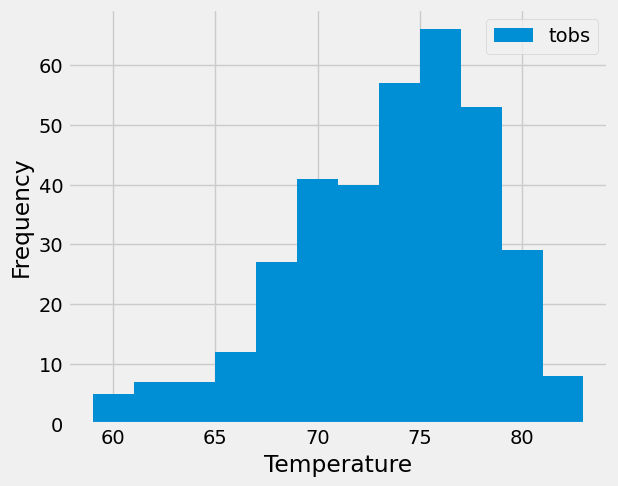

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()